## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
import os
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from storesales.constants import EXTERNAL_DATA_PATH
from storesales.explore.utils import (
    compute_weekly_corr,
    plot_corr_per_store,
    get_holidays_on_sales_fig,
)

## External Data Exploration

Data Source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

### File Structure
- train.csv
- test.csv
- sample_submission.csv
- holidays_events.csv
- oil.csv
- stores.csv
- transactions.csv

In [3]:
train_path = os.path.join(EXTERNAL_DATA_PATH, "train.csv")
test_path = os.path.join(EXTERNAL_DATA_PATH, "test.csv")
# sample_submission_path = os.path.join(EXTERNAL_DATA_PATH, "sample_submission.csv")
holidays_events_path = os.path.join(EXTERNAL_DATA_PATH, "holidays_events.csv")
oil_path = os.path.join(EXTERNAL_DATA_PATH, "oil.csv")
stores_path = os.path.join(EXTERNAL_DATA_PATH, "stores.csv")
transactions_path = os.path.join(EXTERNAL_DATA_PATH, "transactions.csv")

## train.csv

* **Date Gaps**: "2013-12-25", "2014-12-25", "2015-12-25", "2016-12-25"
* **Date**: All stores have the same dates

In [4]:
train_df = pd.read_csv(train_path)

train_df["date"] = pd.to_datetime(train_df["date"])

In [5]:
train_df["day_of_week"] = train_df["date"].dt.dayofweek

In [6]:
print(train_df.head())

   id       date  store_nbr      family  sales  onpromotion  day_of_week
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0            1
1   1 2013-01-01          1   BABY CARE    0.0            0            1
2   2 2013-01-01          1      BEAUTY    0.0            0            1
3   3 2013-01-01          1   BEVERAGES    0.0            0            1
4   4 2013-01-01          1       BOOKS    0.0            0            1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   day_of_week  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(1)
memory usage: 148.8+ MB


In [8]:
print("N NaNs:", train_df.isna().sum().sum())

N NaNs: 0


In [9]:
min_date = train_df["date"].min()
max_date = train_df["date"].max()
full_date_range = pd.date_range(start=min_date, end=max_date)

print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

n_stores = train_df["store_nbr"].nunique()
n_families = train_df["family"].nunique()

print("N families:", n_stores)
print("N stores:", n_families)

Min Date: 2013-01-01 00:00:00
Max Date: 2017-08-15 00:00:00
N families: 54
N stores: 33


In [10]:
each_store_have_all_families = np.all(
    train_df.groupby("store_nbr")["family"].nunique() == n_families
)
print(f"Each store has all {n_families} families: {each_store_have_all_families}")

Each store has all 33 families: True


#### Date Gaps

In [11]:
def intersect_dates_by_store_family(df):
    date_sets = df.groupby(["store_nbr", "family"])["date"].apply(set)
    common_dates = set.intersection(*date_sets)

    first_date_set = date_sets.iloc[0]
    all_same = all(date_set == first_date_set for date_set in date_sets)
    print(f"All stores have the same dates: {all_same}")
    return common_dates

In [12]:
intersect_dates = intersect_dates_by_store_family(train_df)
gaps = full_date_range.difference(intersect_dates)

All stores have the same dates: True


In [13]:
print(f"Date Gaps: {gaps}")

Date Gaps: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


#### Sales Distribution

In [23]:
def normalize_sales_by_row(df: pd.DataFrame) -> pd.DataFrame:
    return df.div(df.sum(axis=1), axis=0) * 100


def normalize_sales_by_col(df: pd.DataFrame) -> pd.DataFrame:
    return df.div(df.sum(), axis=1) * 100

In [24]:
all_sales_df = train_df.groupby(["date"])["sales"].sum().reset_index()

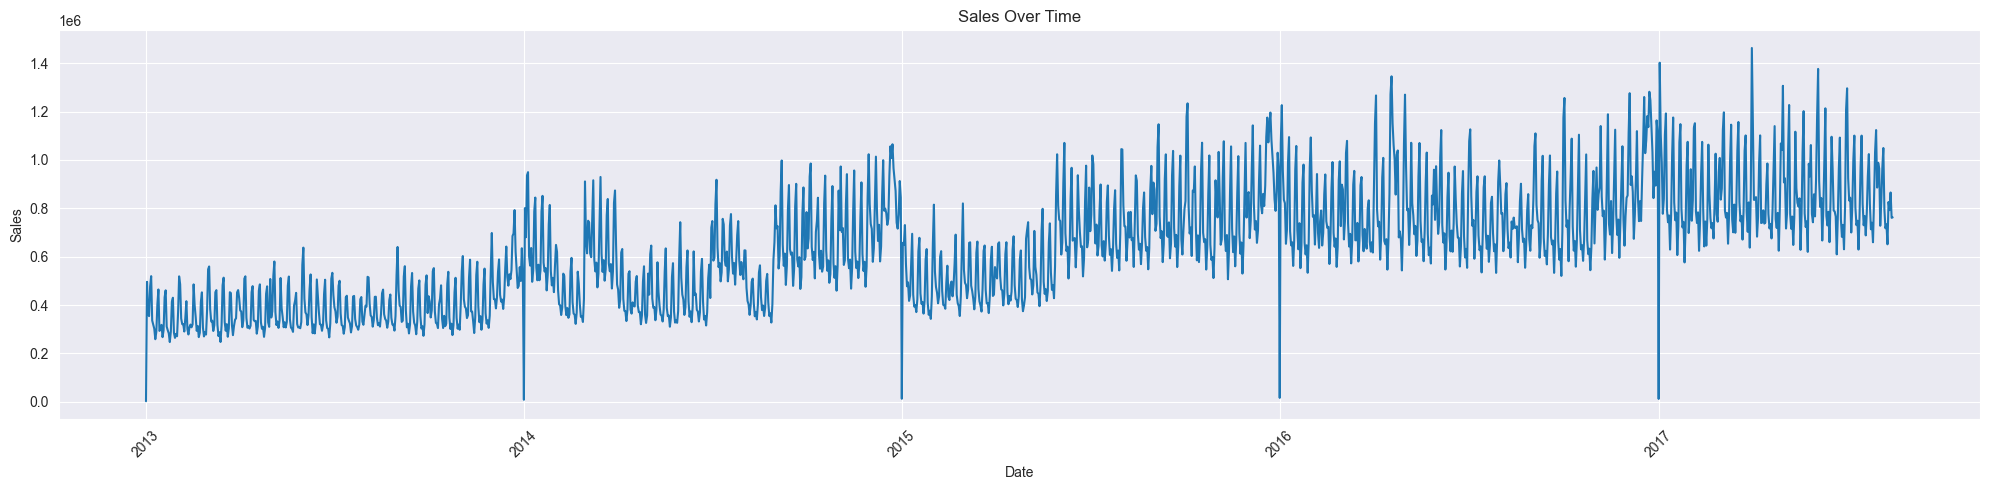

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(all_sales_df["date"], all_sales_df["sales"])

plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

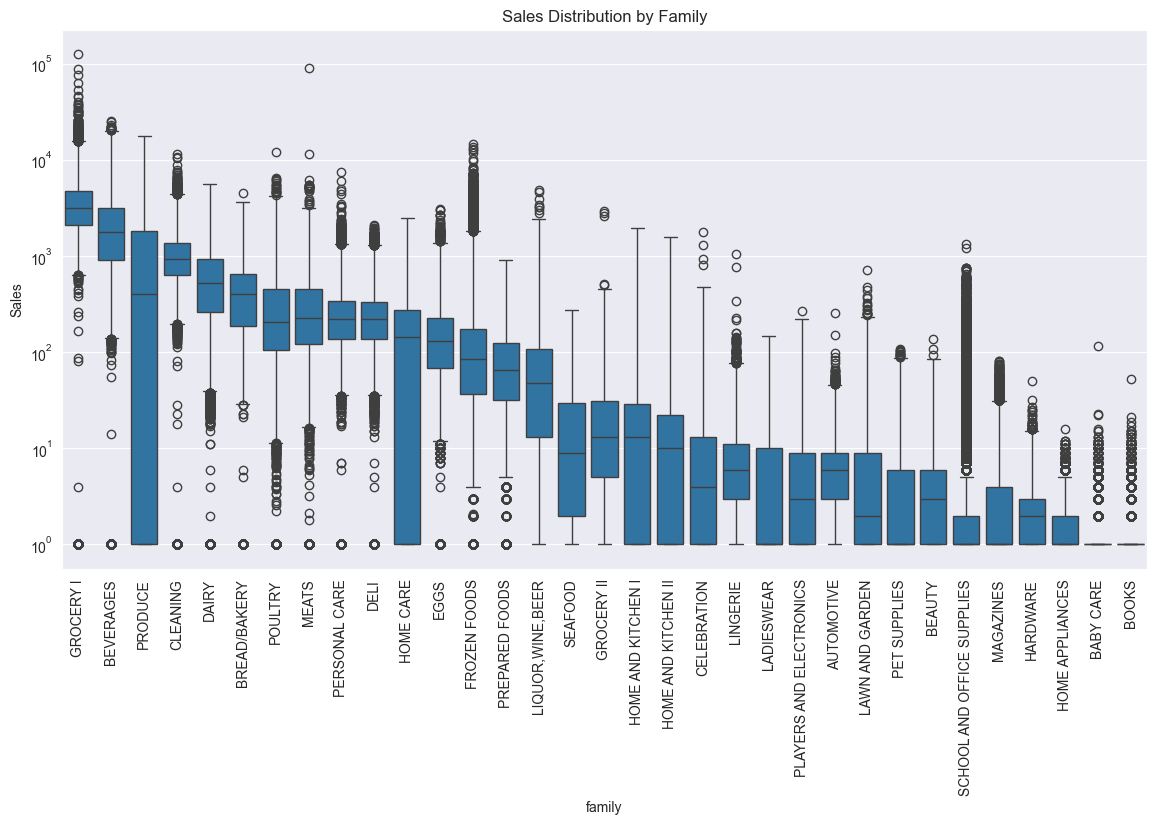

In [17]:
copy_train_df = train_df.copy()
copy_train_df["sales"] += 1

median_sales = train_df.groupby("family")["sales"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=copy_train_df,
    x="family",
    y="sales",
    order=median_sales.index,
    log_scale=True,
)
plt.title("Sales Distribution by Family")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.show()

In [18]:
store_family_sales: pd.DataFrame = (
    train_df.groupby(["store_nbr", "family"])["sales"].sum().unstack()
)
store_family_sales_pct = normalize_sales_by_row(store_family_sales)
family_store_sales_pct = normalize_sales_by_col(store_family_sales)

In [19]:
store_family_sales_pct

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,0.038706,0.000000,0.028674,18.902556,0.001492,4.029634,0.118671,7.624772,7.453892,1.463675,...,0.038169,3.729995,1.537885,0.041357,0.063012,3.383676,0.961325,17.273438,0.002043,0.308865
2,0.042213,0.000390,0.036813,19.269087,0.001109,4.287499,0.062085,7.542050,6.665279,1.908789,...,0.029962,3.942573,2.054219,0.042398,0.044546,3.801205,0.975918,12.903206,0.003572,0.251640
3,0.030995,0.001331,0.032069,22.486449,0.001070,3.837769,0.095975,6.882529,6.808086,1.316650,...,0.040561,2.706888,1.679744,0.038980,0.058962,3.774101,1.225940,17.062183,0.002504,0.354484
4,0.035786,0.000127,0.036436,19.398171,0.001407,3.611279,0.056844,7.878750,7.029122,1.923757,...,0.031090,3.291805,2.030614,0.037795,0.048113,3.998062,0.888038,13.958911,0.001851,0.291232
5,0.058965,0.001379,0.055694,16.250419,0.001475,4.122870,0.167877,10.695900,5.587868,2.663290,...,0.042129,3.059851,2.887085,0.020516,0.051461,2.691249,0.949123,10.605050,0.005214,0.143397
6,0.035849,0.000048,0.037878,20.104711,0.000302,3.649597,0.062552,8.263792,6.401106,2.284656,...,0.024464,3.312170,2.148983,0.039510,0.051958,4.220033,0.940284,11.489122,0.001771,0.290586
7,0.026529,0.000178,0.022789,20.750218,0.000783,4.015271,0.070366,6.569998,7.655477,1.055975,...,0.041451,3.265108,1.332711,0.024046,0.043180,3.779429,1.120984,20.691689,0.001989,0.359679
8,0.029153,0.000466,0.039693,20.814227,0.001040,4.157133,0.081904,6.965423,7.784452,1.538160,...,0.045481,2.867890,1.808601,0.056076,0.062169,3.306000,1.170475,16.895710,0.002328,0.307770
9,0.088446,0.001272,0.035150,17.483884,0.000000,3.619312,0.061558,10.978521,4.755591,3.727847,...,0.010564,2.403576,2.827137,0.021568,0.043526,3.085467,0.565994,6.179693,0.038585,0.107663


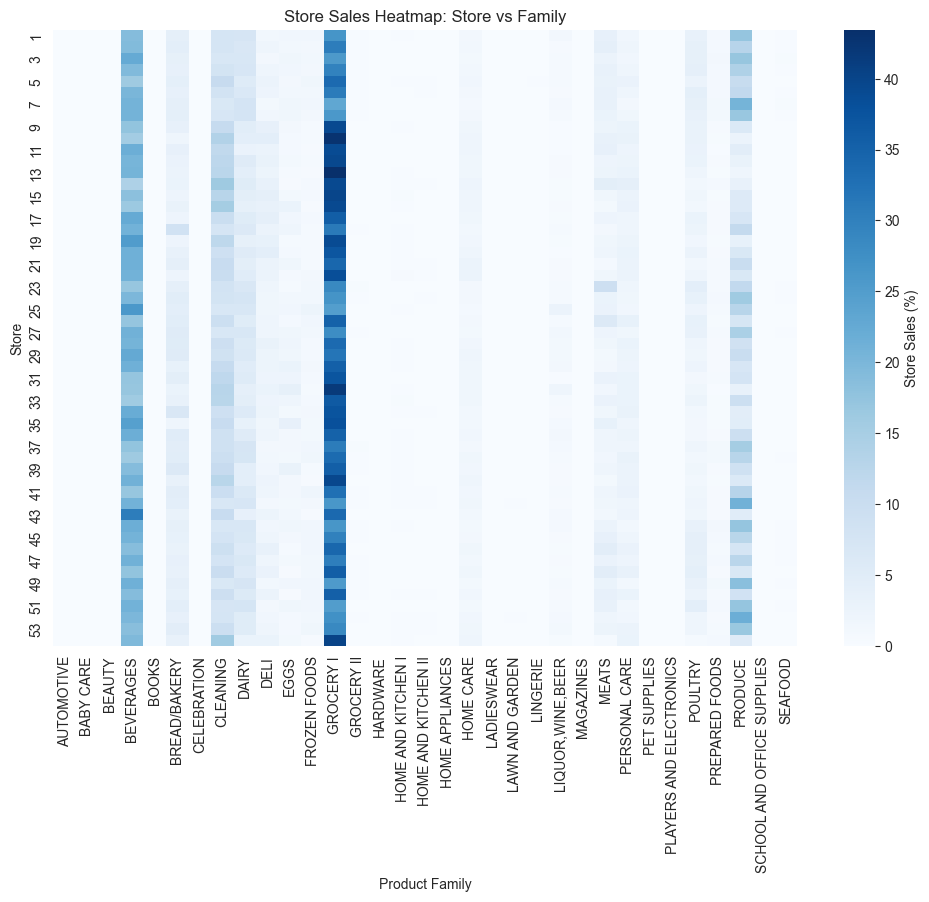

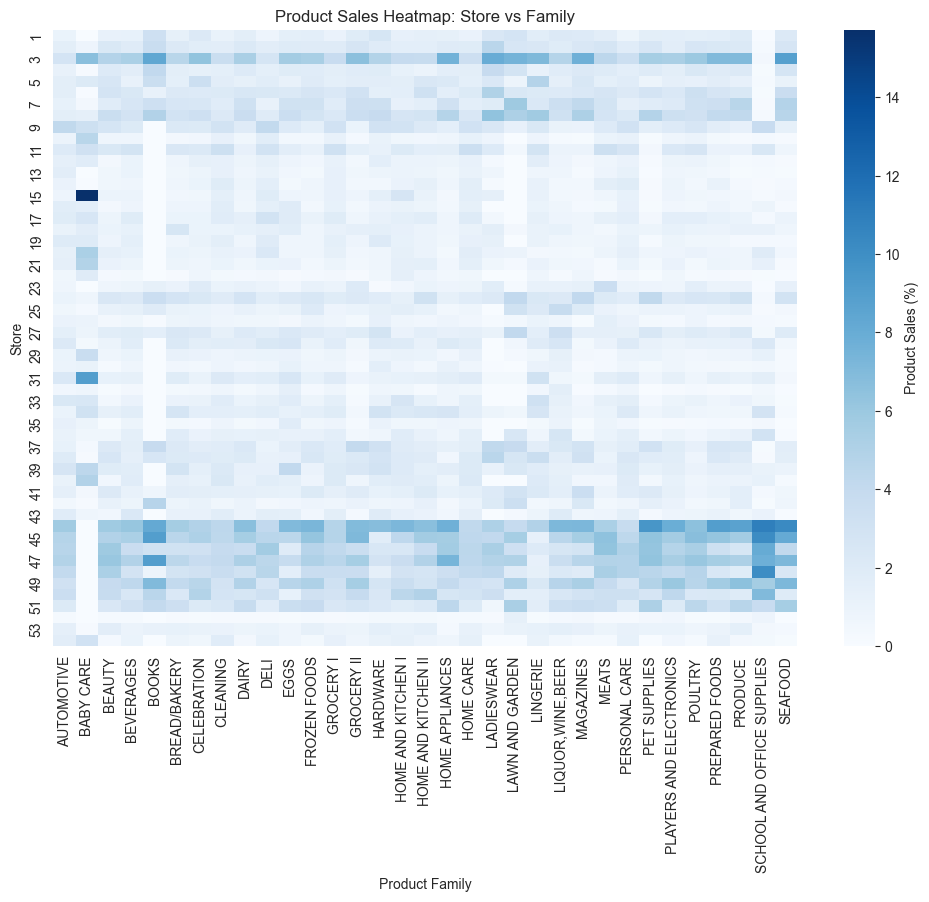

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(store_family_sales_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"})
plt.title("Store Sales Heatmap: Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(
    family_store_sales_pct, cmap="Blues", cbar_kws={"label": "Product Sales (%)"}
)
plt.title("Product Sales Heatmap: Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

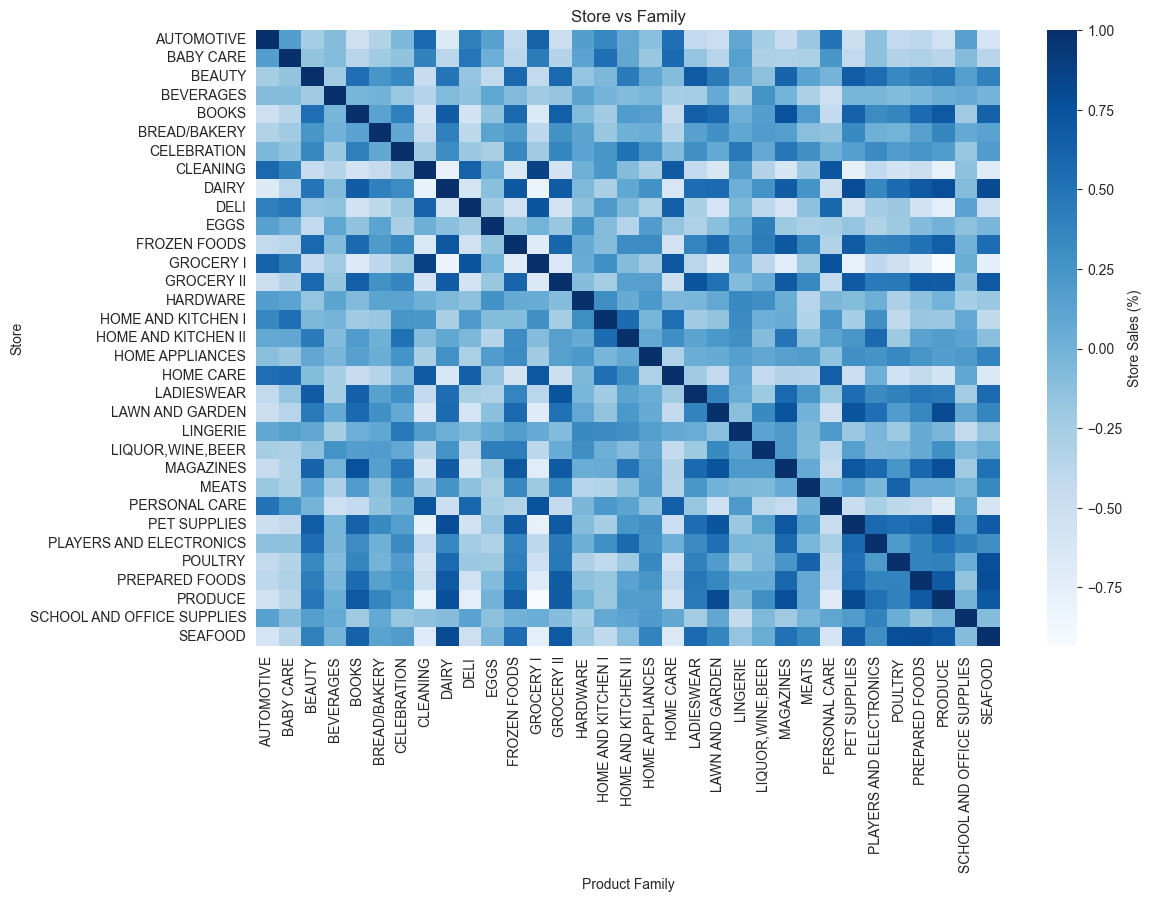

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    store_family_sales_pct.corr(), cbar_kws={"label": "Store Sales (%)"}, cmap="Blues"
)
plt.title("Store vs Family")
plt.xlabel("Product Family")
plt.ylabel("Store")
plt.show()

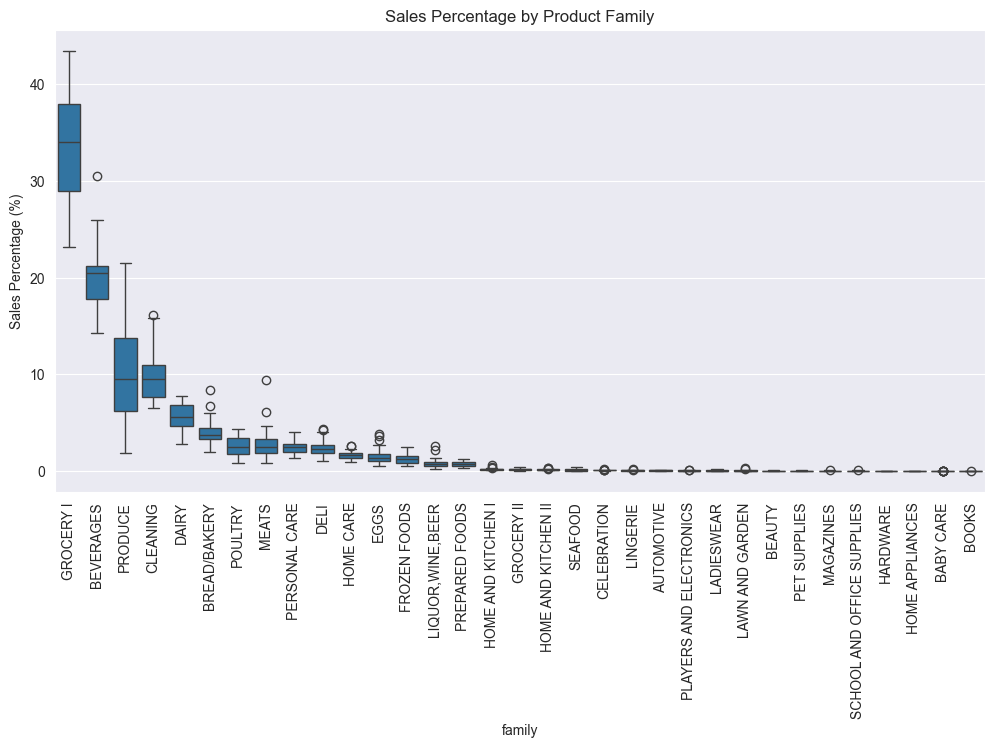

In [22]:
store_family_sales_pct_no_idx = store_family_sales_pct.reset_index().copy()

store_family_sales_pct_melted = store_family_sales_pct_no_idx.melt(
    id_vars="store_nbr", var_name="family", value_name="sales_pct"
)
median_sales_pct = (
    store_family_sales_pct_melted.groupby("family")["sales_pct"]
    .median()
    .sort_values(ascending=False)
)
store_family_sales_pct_melted["sales_pct"] += 0.01

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=store_family_sales_pct_melted,
    x="family",
    y="sales_pct",
    order=median_sales_pct.index,
)
plt.title("Sales Percentage by Product Family")
plt.ylabel("Sales Percentage (%)")
plt.xticks(rotation=90)
plt.show()

In [23]:
store_family_sales_pct_melted.head()

,store_nbr,family,sales_pct
0,1,AUTOMOTIVE,0.048706
1,2,AUTOMOTIVE,0.052213
2,3,AUTOMOTIVE,0.040995
3,4,AUTOMOTIVE,0.045786
4,5,AUTOMOTIVE,0.068965


## test.csv

In [40]:
test_df = pd.read_csv(test_path)
test_df["date"] = pd.to_datetime(test_df["date"])

In [41]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [43]:
print("N NaNs:", test_df.isna().sum().sum())

N NaNs: 0


In [44]:
min_test_date = test_df["date"].min()
max_test_date = test_df["date"].max()
test_days_range = (max_test_date - min_test_date).days + 1

print(f"Min Test Date: {min_test_date}")
print(f"Max Test Date: {max_test_date}")
print(f"Test Date Range: {test_days_range} days")

Min Test Date: 2017-08-16 00:00:00
Max Test Date: 2017-08-31 00:00:00
Test Date Range: 16 days


In [45]:
is_no_gaps = n_families * n_stores * test_days_range == test_df.shape[0]
print(f"No gaps in test data: {is_no_gaps}")

No gaps in test data: True


## holidays_events.csv

In [15]:
holidays_events_df = pd.read_csv(holidays_events_path)
holidays_events_df["date"] = pd.to_datetime(holidays_events_df["date"])

In [19]:
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [22]:
holidays_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [29]:
holidays_events_df["type"].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [30]:
holidays_events_df["locale"].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [23]:
holidays_events_df[holidays_events_df["transferred"]]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [24]:
holidays_events_df[holidays_events_df["date"] == "2012-10-12"]

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False


In [25]:
holidays_events_df[holidays_events_df["type"] == "Transfer"]

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [17]:
min_holiday_date = holidays_events_df["date"].min()
max_holiday_date = holidays_events_df["date"].max()

print(f"Min Holiday Date: {min_holiday_date}")
print(f"Max Holiday Date: {max_holiday_date}")

Min Holiday Date: 2012-03-02 00:00:00
Max Holiday Date: 2017-12-26 00:00:00


In [18]:
print("N NaNs:", holidays_events_df.isna().sum().sum())

N NaNs: 0


In [19]:
n_holidays = holidays_events_df["description"].nunique()

print("N unique holidays:", n_holidays)

N unique holidays: 103


#### Holidays in Train Period

In [31]:
start_holiday_date = min_date - pd.DateOffset(months=1)
end_holiday_date = max_date + pd.DateOffset(months=2)

condition = (holidays_events_df["date"] >= start_holiday_date) & (
    holidays_events_df["date"] <= end_holiday_date
)

In [32]:
limited_holidays_df = holidays_events_df[condition]

In [83]:
holiday_to_sales_fig = get_holidays_on_sales_fig(all_sales_df, holidays_events_df)

In [84]:
holiday_to_sales_fig.show()

#### Holidays in Test Period

In [35]:
condition = (holidays_events_df["date"] >= min_test_date) & (
    holidays_events_df["date"] <= max_test_date
)

In [36]:
holidays_events_df[condition]

,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


## oil.csv

* **Data Gaps**: up to 3 days.
* **Nones**: There are no NaNs.
* **Test Period**: oil date covers the test period.

In [33]:
oil_df = pd.read_csv(oil_path)
oil_df["date"] = pd.to_datetime(oil_df["date"])
oil_df.sort_values("date", inplace=True)

In [34]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [35]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [36]:
print("N NaNs:", oil_df.isna().sum().sum())

N NaNs: 43


#### Test Period

In [47]:
con = oil_df["date"] >= min_test_date
oil_df[con]

,date,dcoilwtico
1206,2017-08-16,46.80
1207,2017-08-17,47.07
1208,2017-08-18,48.59
1209,2017-08-21,47.39
1210,2017-08-22,47.65
1211,2017-08-23,48.45
1212,2017-08-24,47.24
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46


#### Date Gaps

In [48]:
unique_gaps_ranges = oil_df["date"].diff().dt.days.unique()

print("Unique Gaps Ranges:", unique_gaps_ranges)

Unique Gaps Ranges: [nan  1.  3.]


#### Plotting Oil Prices Over Time

In [87]:
oil_df.set_index("date", inplace=True)

In [89]:
oil_df = oil_df.asfreq("D")

In [91]:
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].ffill()

In [98]:
oil_df = oil_df.dropna()

In [99]:
oil_df.head()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.12
2013-01-06,93.12


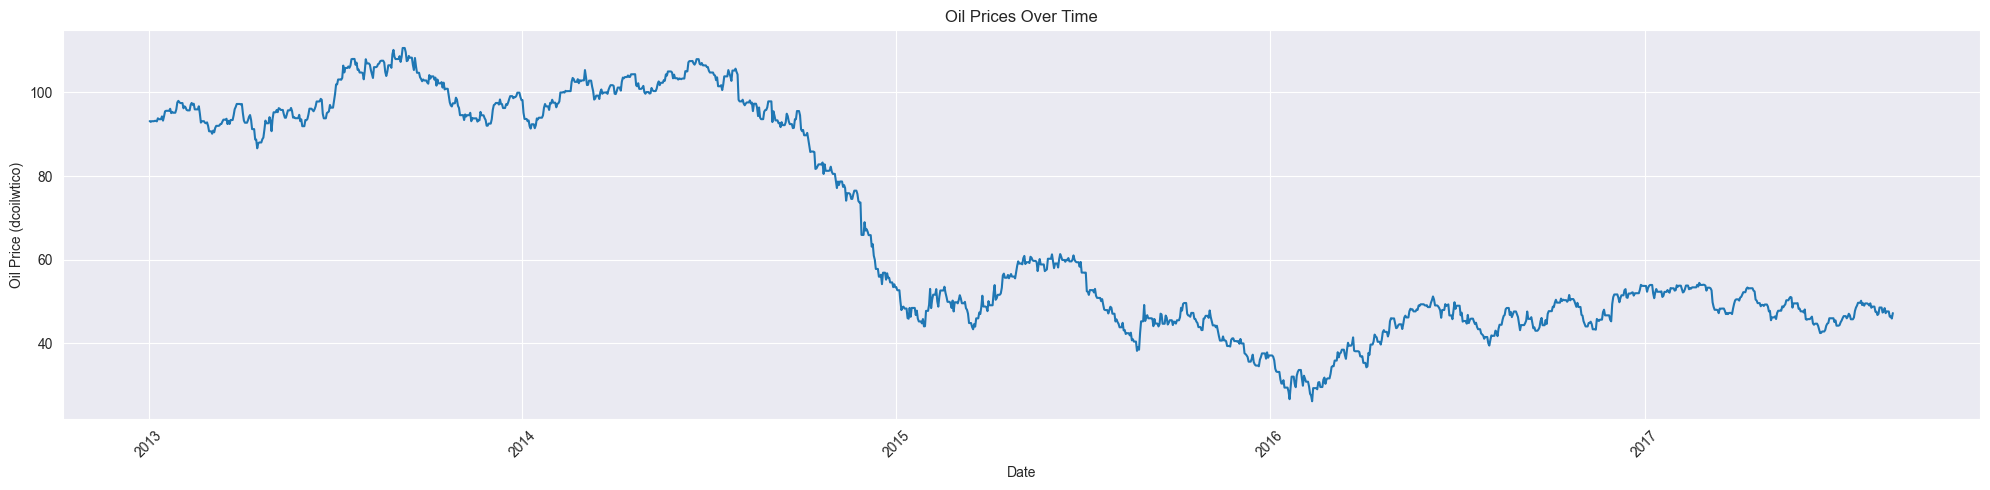

In [100]:
plt.figure(figsize=(20, 5))
plt.plot(oil_df.index, oil_df["dcoilwtico"])

plt.title("Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price (dcoilwtico)")

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Oil Correlation with Sales

##### Global Correlation

In [101]:
sales_per_day = train_df.groupby("date")["sales"].sum()

In [102]:
oil_to_sales = pd.merge(
    sales_per_day, oil_df, left_index=True, right_on="date", how="inner"
)

In [103]:
corr = oil_to_sales["sales"].corr(oil_to_sales["dcoilwtico"])

In [104]:
print(f"Correlation between oil prices and sales: {corr}")

Correlation between oil prices and sales: -0.6268562268443909


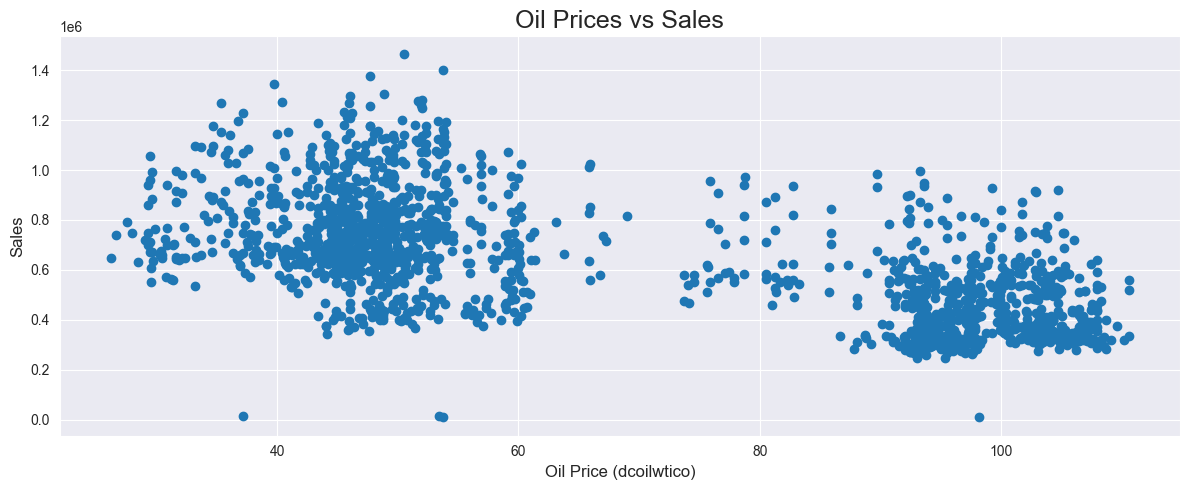

In [105]:
plt.figure(figsize=(12, 5))
plt.scatter(oil_to_sales["dcoilwtico"], oil_to_sales["sales"])

plt.title("Oil Prices vs Sales", fontsize=18)
plt.xlabel("Oil Price (dcoilwtico)", fontsize=12)
plt.ylabel("Sales", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

##### Per Store Correlation

In [106]:
store_sales_per_day = (
    train_df.groupby(["store_nbr", "date"])["sales"].sum().reset_index()
)

In [107]:
store_sales_oil = pd.merge(
    store_sales_per_day, oil_df, left_on="date", right_on="date", how="inner"
)

In [108]:
store_sales_oil_corr = store_sales_oil.groupby("store_nbr")[
    ["sales", "dcoilwtico"]
].corr()
store_sales_oil_corr = store_sales_oil_corr.iloc[0::2, -1].reset_index(
    level=1, drop=True
)

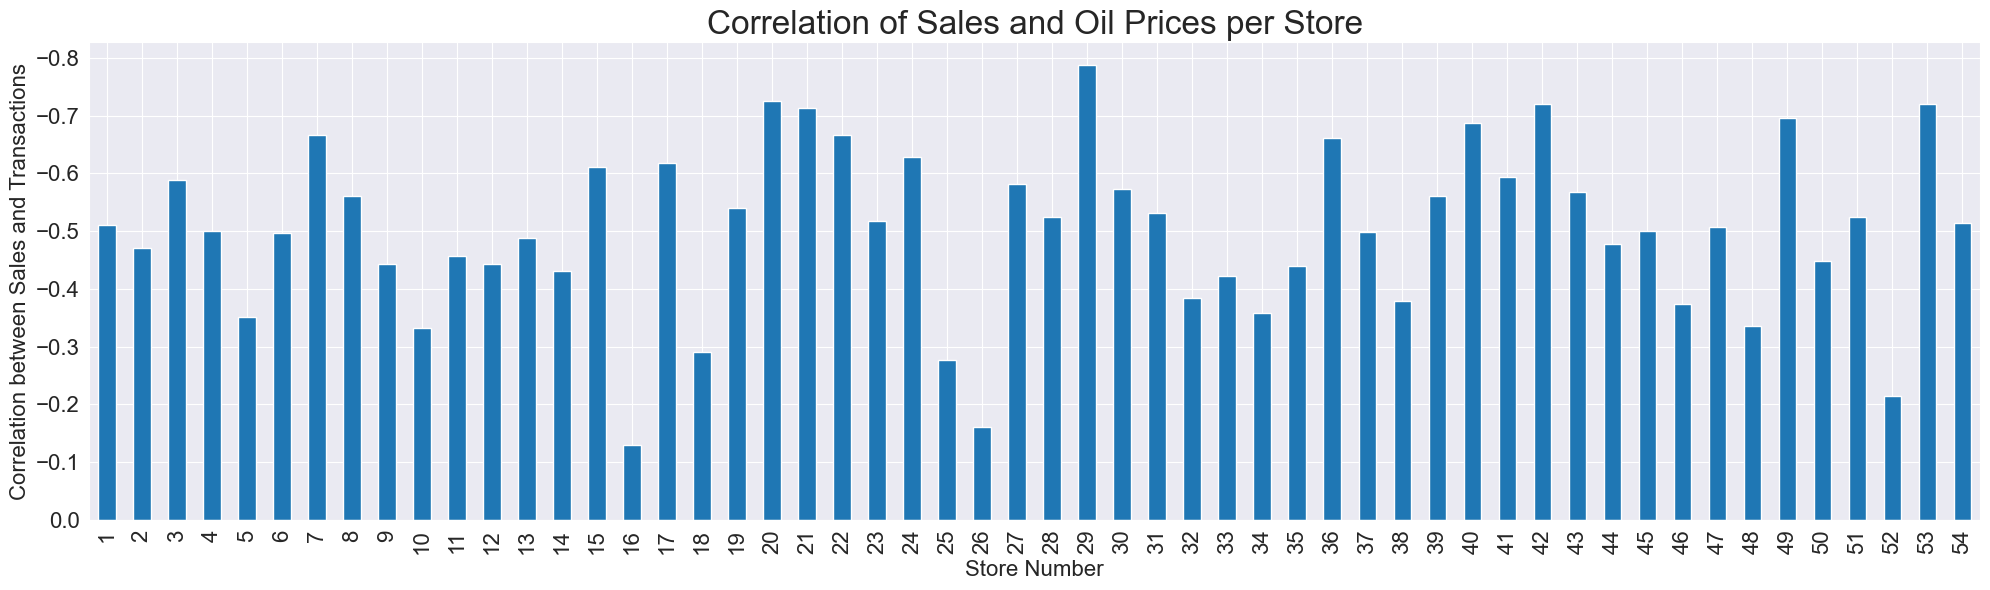

In [109]:
plot_corr_per_store(
    store_sales_oil_corr,
    "Correlation of Sales and Oil Prices per Store",
    reverse_yaxis=True,
)

##### Per Week Correlation

In [111]:
store_sales_oil["bin"] = (
    store_sales_oil["date"].dt.isocalendar().week.astype(str)
    + "-"
    + store_sales_oil["date"].dt.year.astype(str)
)

In [112]:
store_sales_oil[store_sales_oil["bin"] == "1-2013"]

,store_nbr,date,sales,dcoilwtico,week
0,1,2013-01-02,7417.148000,93.14,1-2013
1,1,2013-01-03,5873.244001,92.97,1-2013
2,1,2013-01-04,5919.879001,93.12,1-2013
3,1,2013-01-05,6318.785010,93.12,1-2013
4,1,2013-01-06,2199.087000,93.12,1-2013
...,...,...,...,...,...
89201,54,2013-01-04,3266.966000,93.12,1-2013
89202,54,2013-01-05,4394.549000,93.12,1-2013
89203,54,2013-01-06,6330.296000,93.12,1-2013
89560,54,2013-12-30,6458.005995,98.90,1-2013


In [113]:
columns = ["sales", "dcoilwtico"]

weekly_oil_corr = (
    store_sales_oil.groupby(["store_nbr", "bin"])
    .apply(compute_weekly_corr, columns, include_groups=False)
    .reset_index(name="corr")
)

In [114]:
weekly_oil_corr["abs_corr"] = weekly_oil_corr["corr"].abs()
mean_abs_corr_per_store = weekly_oil_corr.groupby("store_nbr")["abs_corr"].mean()

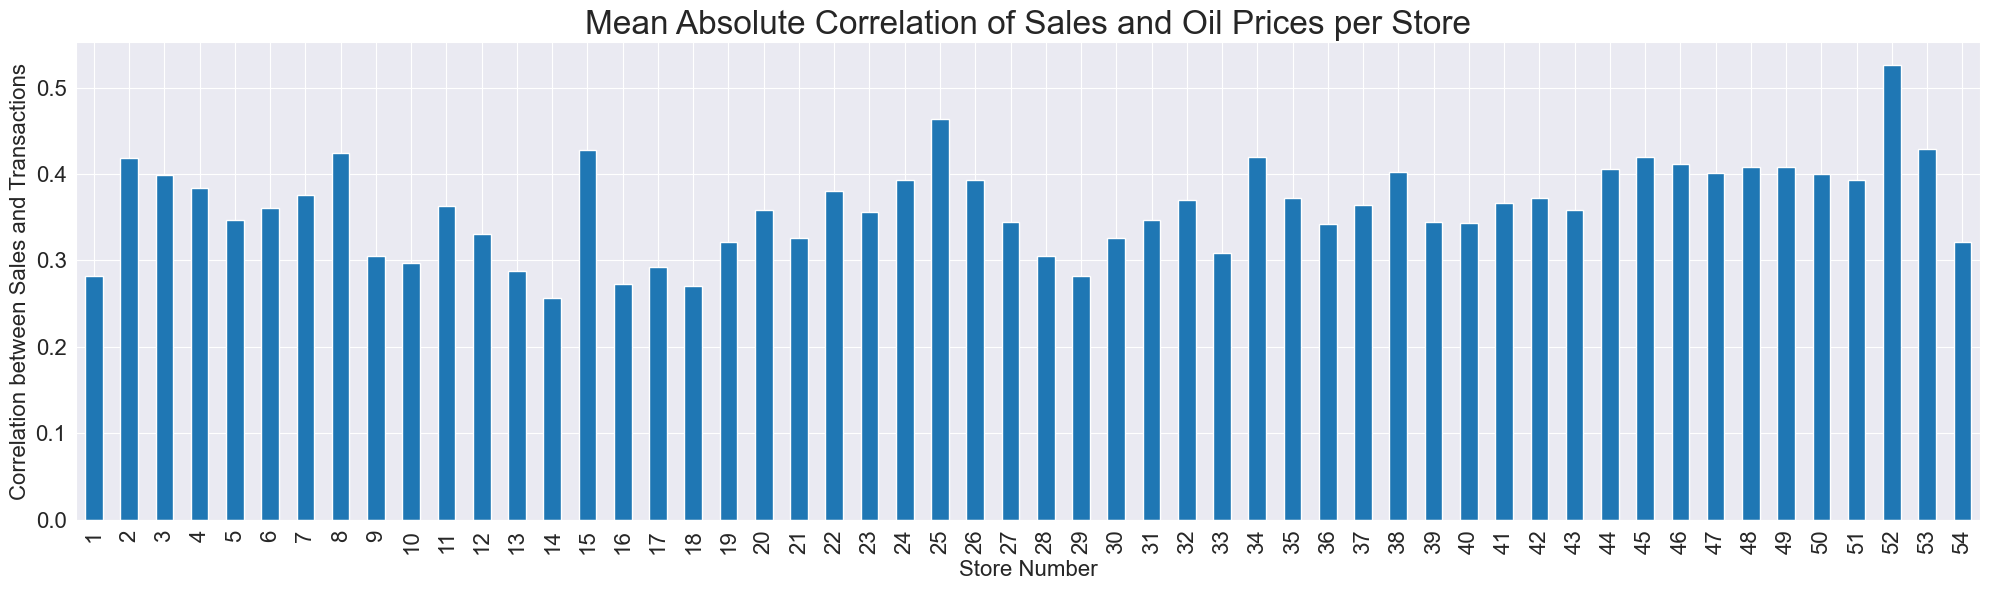

In [116]:
plot_corr_per_store(
    mean_abs_corr_per_store,
    "Mean Absolute Correlation of Sales and Oil Prices per Store",
)

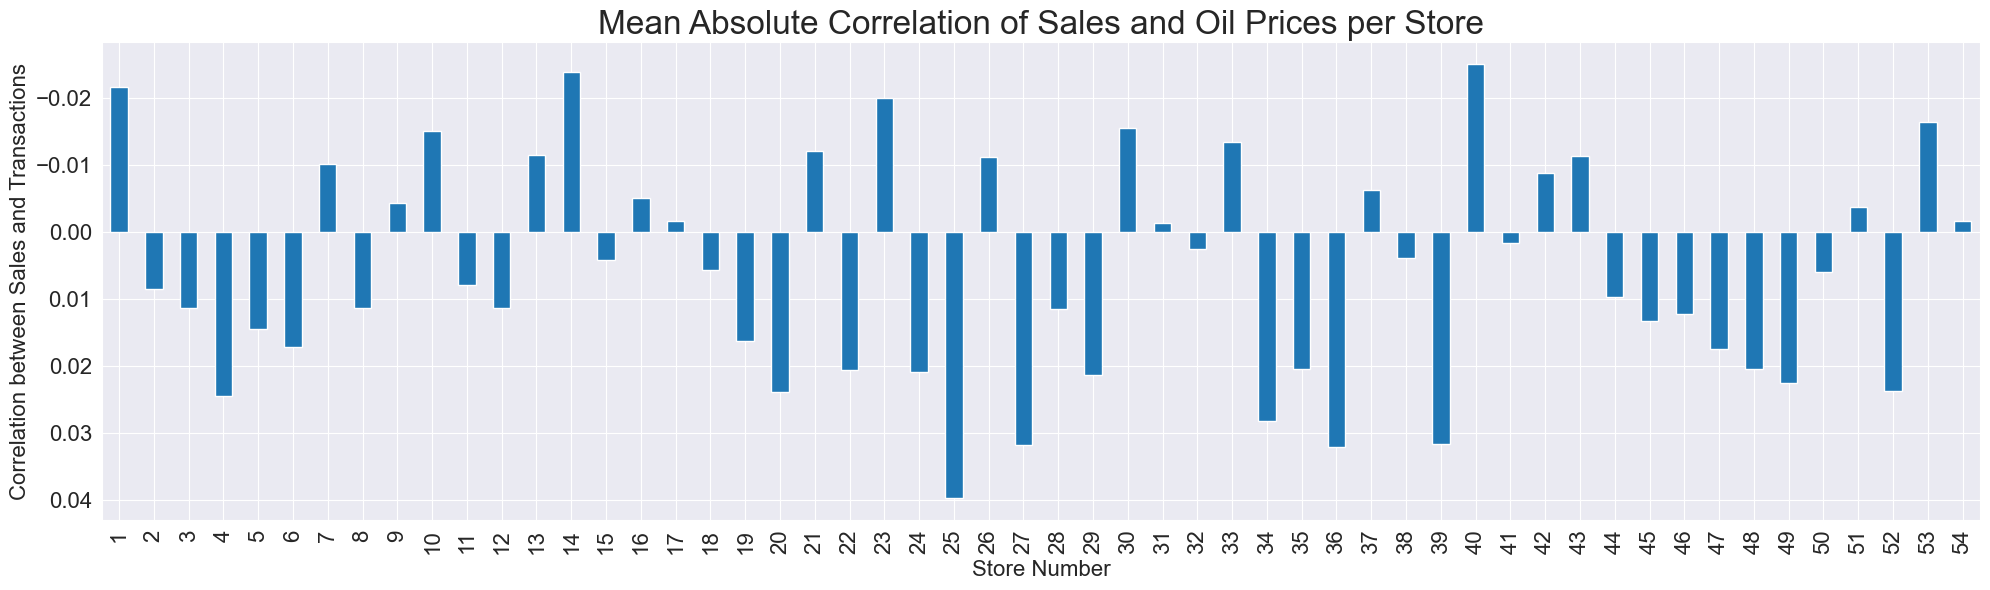

In [117]:
plot_corr_per_store(
    weekly_oil_corr.groupby("store_nbr")["corr"].mean(),
    "Mean Absolute Correlation of Sales and Oil Prices per Store",
    reverse_yaxis=True,
)

##### Weekly Global abs Correlation

In [108]:
mean_abs_corr = weekly_oil_corr["abs_corr"].mean()

In [109]:
print(f"Mean Absolute Correlation of Sales and Oil Prices: {mean_abs_corr}")

Mean Absolute Correlation of Sales and Oil Prices: 0.6356007795126201


## stores.csv

In [59]:
stores_df = pd.read_csv(stores_path)

In [60]:
stores_df["city"].nunique()

22

In [61]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [62]:
print("N NaNs:", stores_df.isna().sum().sum())

N NaNs: 0


In [63]:
stores_df["type"].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

#### Sales by Store Type

In [64]:
store_sales = train_df.groupby("store_nbr")["sales"].sum()

In [65]:
store_sales_by_type = pd.merge(
    store_sales, stores_df, left_index=True, right_on="store_nbr", how="inner"
)

In [66]:
sales_per_type = store_sales_by_type.groupby("type")["sales"].sum()

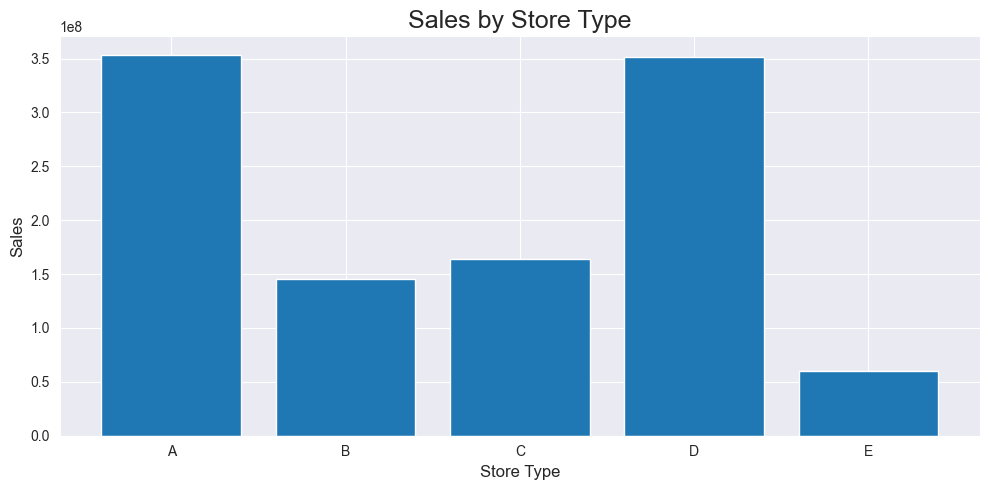

In [67]:
plt.figure(figsize=(10, 5))
plt.bar(sales_per_type.index, sales_per_type.values)

plt.title("Sales by Store Type", fontsize=18)
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("Sales", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Family Sales by Store Type

In [68]:
store_family_sales_by_type = pd.merge(
    store_family_sales,
    stores_df[["type", "store_nbr"]],
    left_index=True,
    right_on="store_nbr",
    how="inner",
)
store_family_sales_by_type.drop("store_nbr", axis=1, inplace=True)

store_family_sales_by_type = store_family_sales_by_type.groupby("type").sum()

In [69]:
store_family_sales_by_type_pct = normalize_sales_by_row(store_family_sales_by_type)
family_store_sales_by_type_pct = normalize_sales_by_col(store_family_sales_by_type)

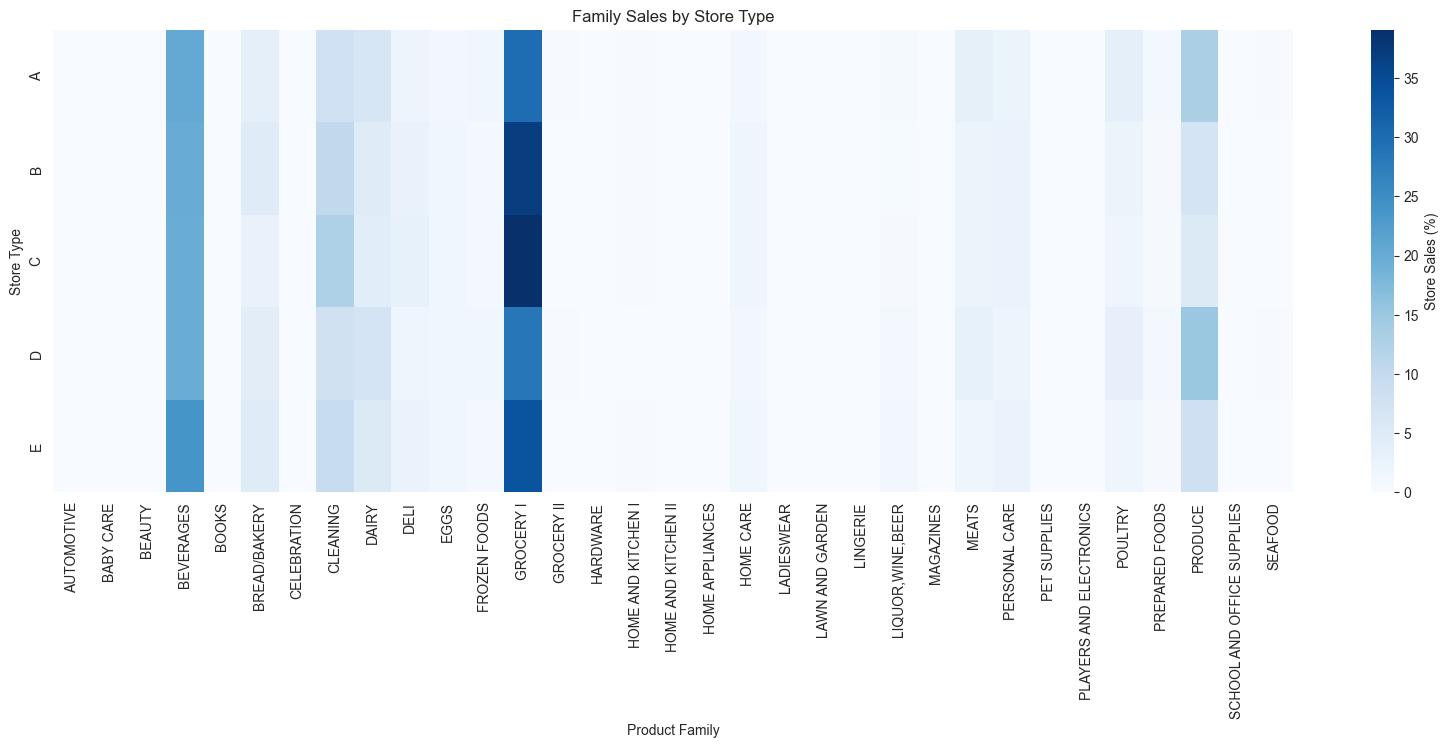

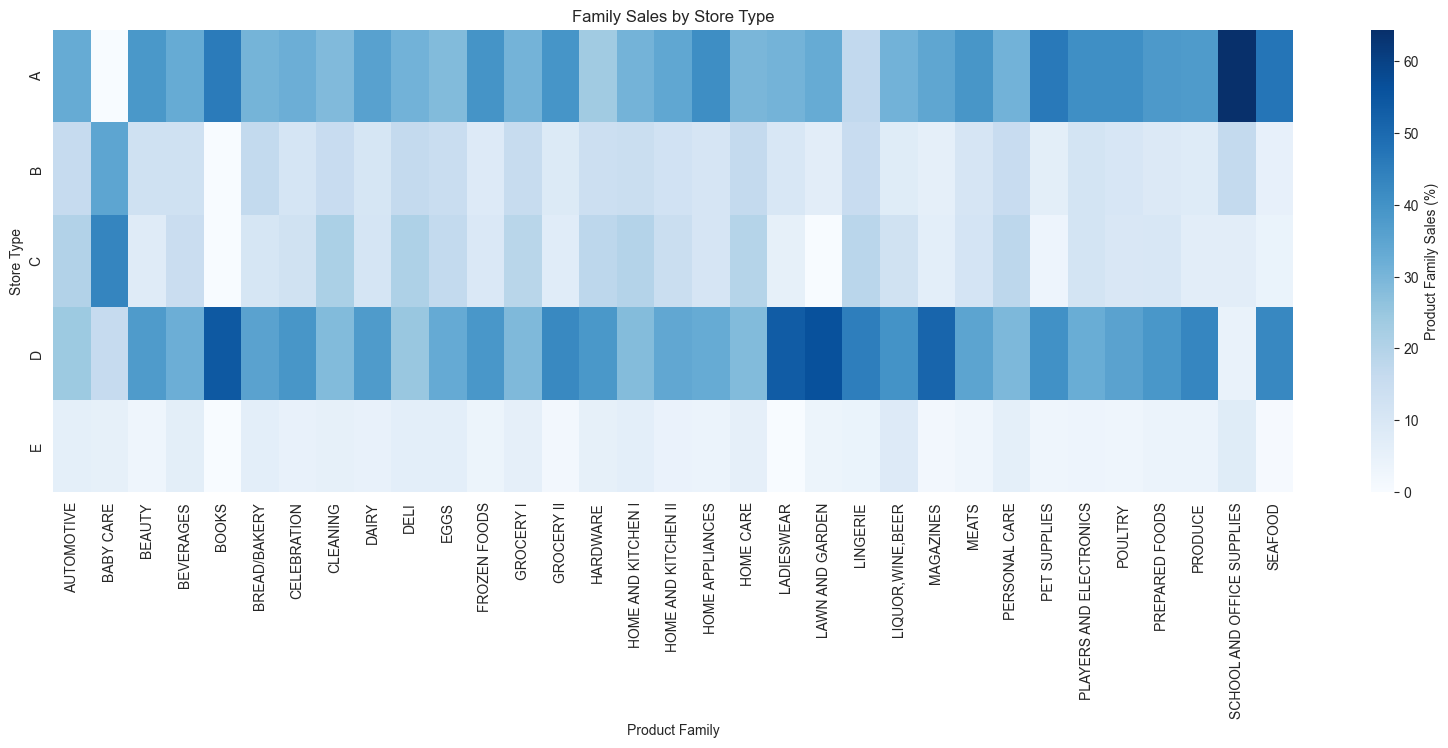

In [70]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    store_family_sales_by_type_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Family Sales by Store Type")
plt.xlabel("Product Family")
plt.ylabel("Store Type")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    family_store_sales_by_type_pct,
    cmap="Blues",
    cbar_kws={"label": "Product Family Sales (%)"},
)
plt.title("Family Sales by Store Type")
plt.xlabel("Product Family")
plt.ylabel("Store Type")
plt.show()

#### Sales to Day of Week

In [71]:
store_to_train_df = pd.merge(
    train_df, stores_df, left_on="store_nbr", right_on="store_nbr", how="inner"
)

In [72]:
family_sales_by_dayofweek = (
    train_df.groupby(["day_of_week", "family"])["sales"].sum().unstack()
)
store_sales_by_dayofweek = (
    train_df.groupby(["day_of_week", "store_nbr"])["sales"].sum().unstack()
)
store_type_sales_by_dayofweek = (
    store_to_train_df.groupby(["day_of_week", "type"])["sales"].sum().unstack()
)
store_cluster_sales_by_dayofweek = (
    store_to_train_df.groupby(["day_of_week", "cluster"])["sales"].sum().unstack()
)

In [73]:
family_sales_by_dayofweek_pct = normalize_sales_by_row(family_sales_by_dayofweek)
store_sales_by_dayofweek_pct = normalize_sales_by_row(store_sales_by_dayofweek)
store_type_sales_by_dayofweek_pct = normalize_sales_by_row(
    store_type_sales_by_dayofweek
)
store_cluster_sales_by_dayofweek_pct = normalize_sales_by_row(
    store_cluster_sales_by_dayofweek
)

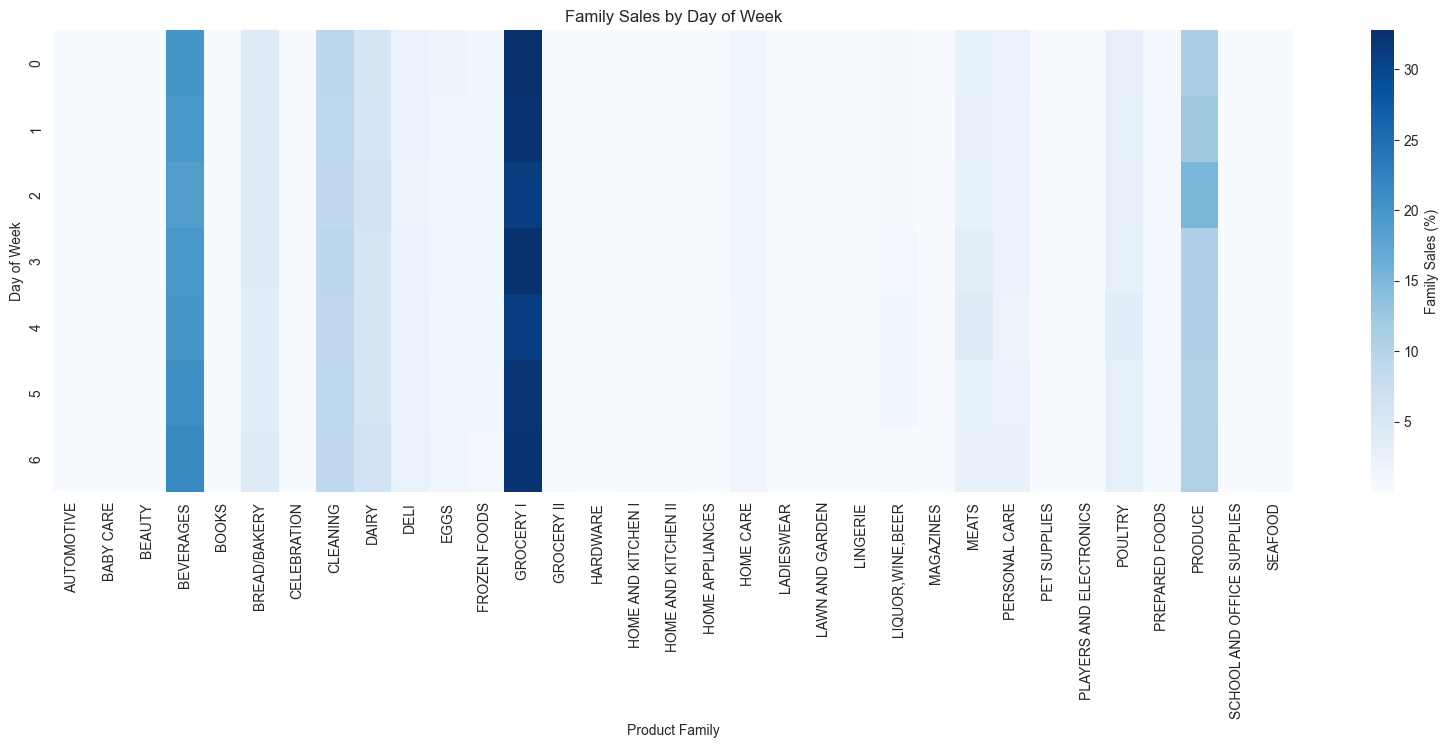

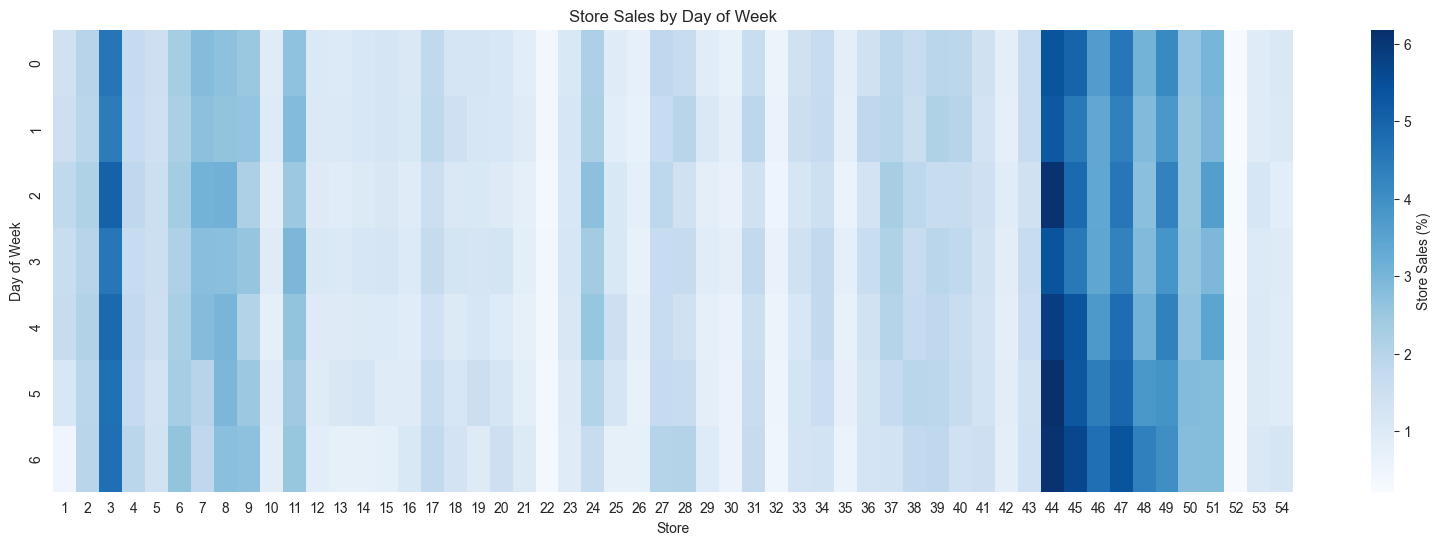

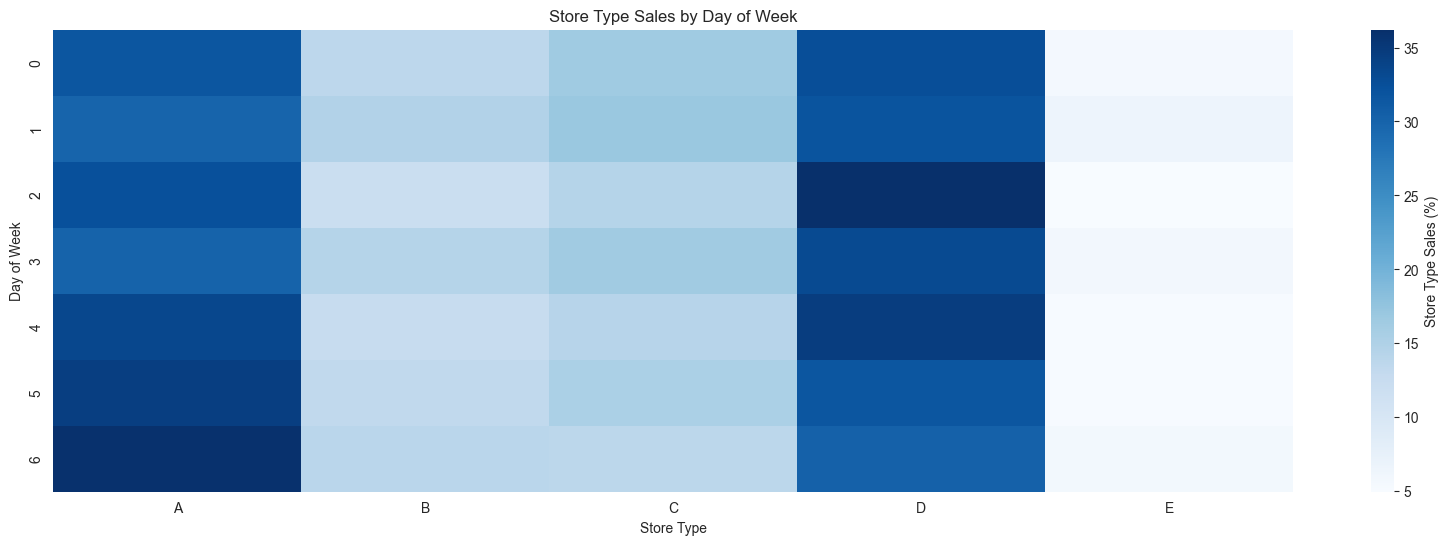

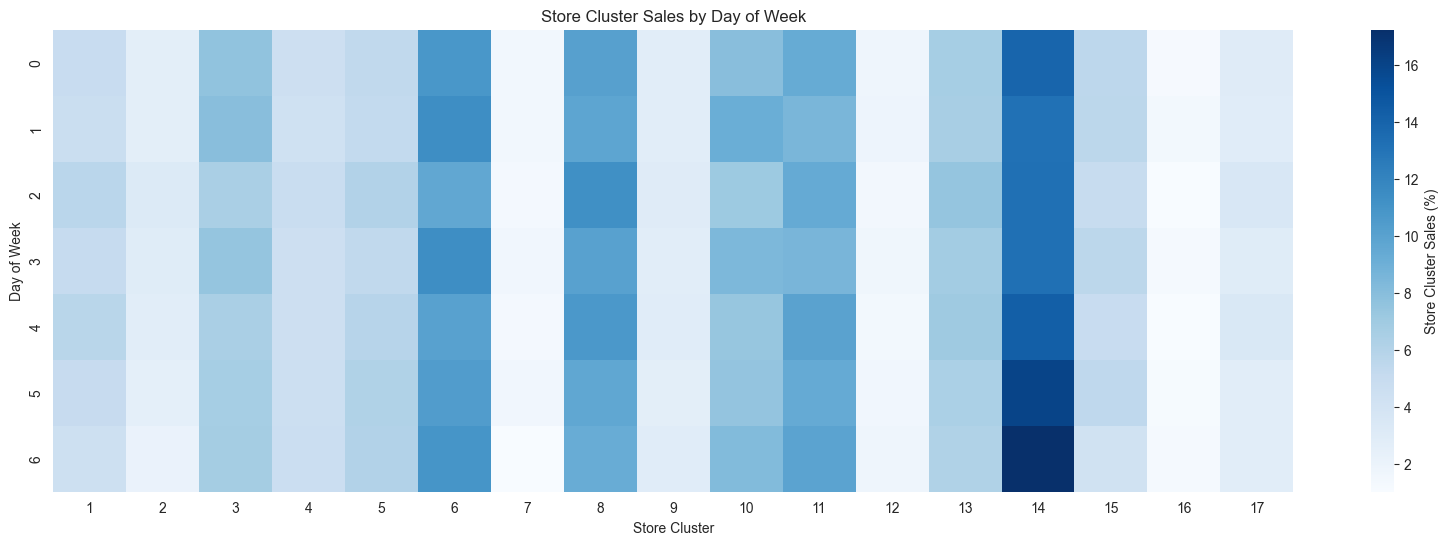

In [74]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    family_sales_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Family Sales (%)"}
)
plt.title("Family Sales by Day of Week")
plt.xlabel("Product Family")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_sales_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Store Sales by Day of Week")
plt.xlabel("Store")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_type_sales_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Type Sales (%)"},
)
plt.title("Store Type Sales by Day of Week")
plt.xlabel("Store Type")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    store_cluster_sales_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Cluster Sales (%)"},
)
plt.title("Store Cluster Sales by Day of Week")
plt.xlabel("Store Cluster")
plt.ylabel("Day of Week")
plt.show()

In [75]:
# how much of the product are sold on each day of the week
sales_to_family_by_dayofweek_pct = normalize_sales_by_col(family_sales_by_dayofweek)

# how much of the store sales are on each day of the week
sales_to_store_by_dayofweek_pct = normalize_sales_by_col(store_sales_by_dayofweek)

# how much of the store type sales are on each day of the week
sales_to_store_type_by_dayofweek_pct = normalize_sales_by_col(
    store_type_sales_by_dayofweek
)

# how much of the store cluster sales are on each day of the week
sales_to_store_cluster_by_dayofweek_pct = normalize_sales_by_col(
    store_cluster_sales_by_dayofweek
)

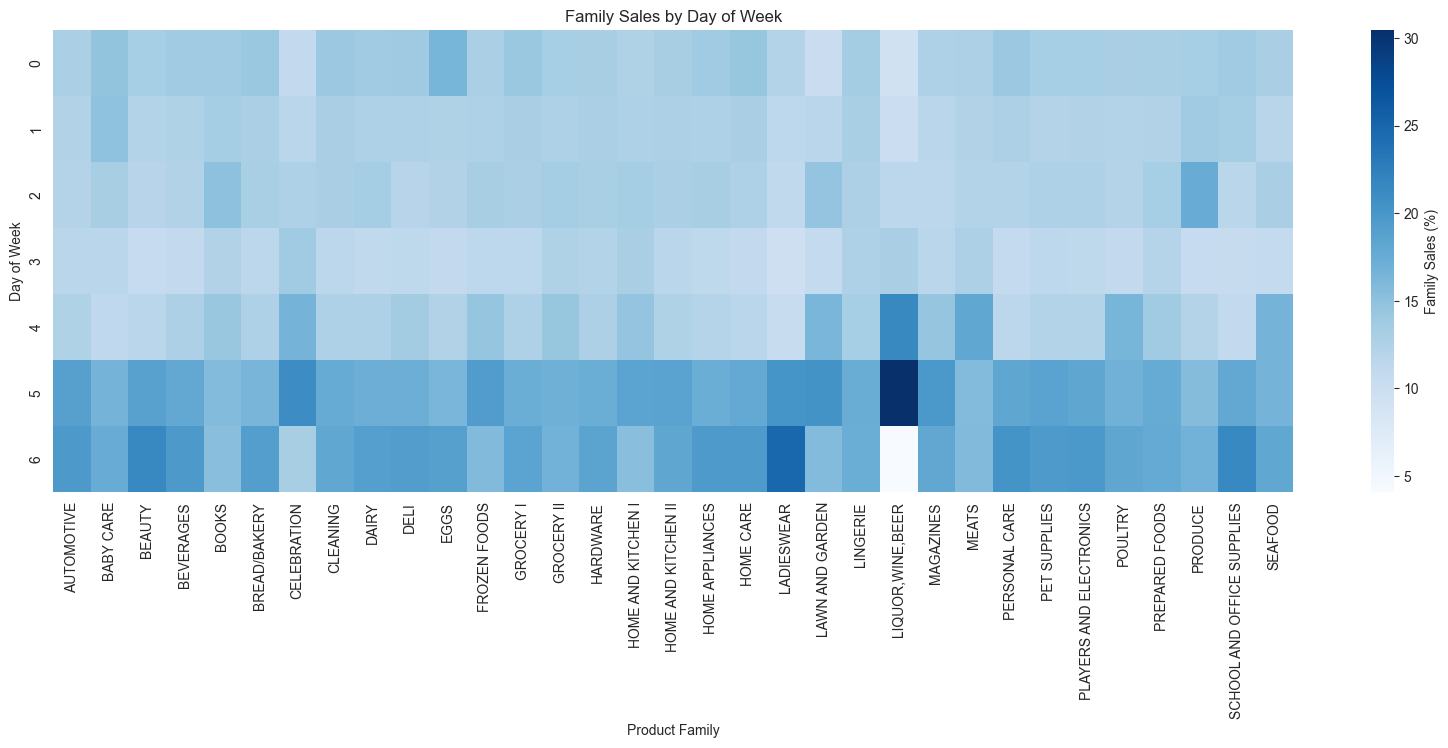

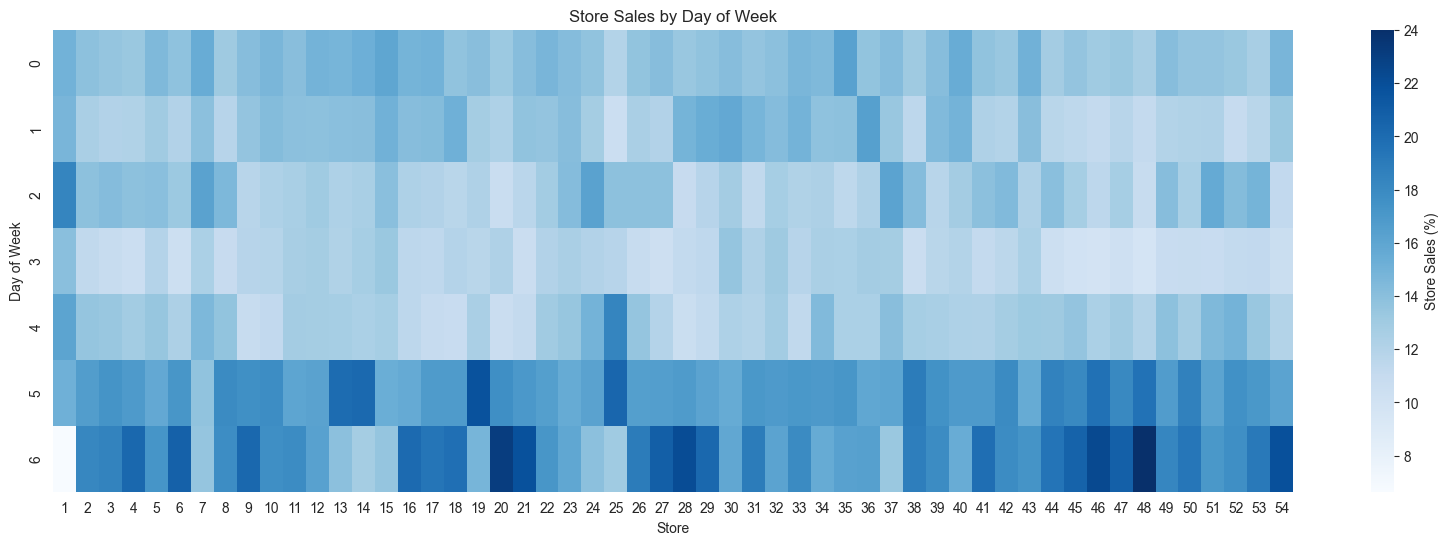

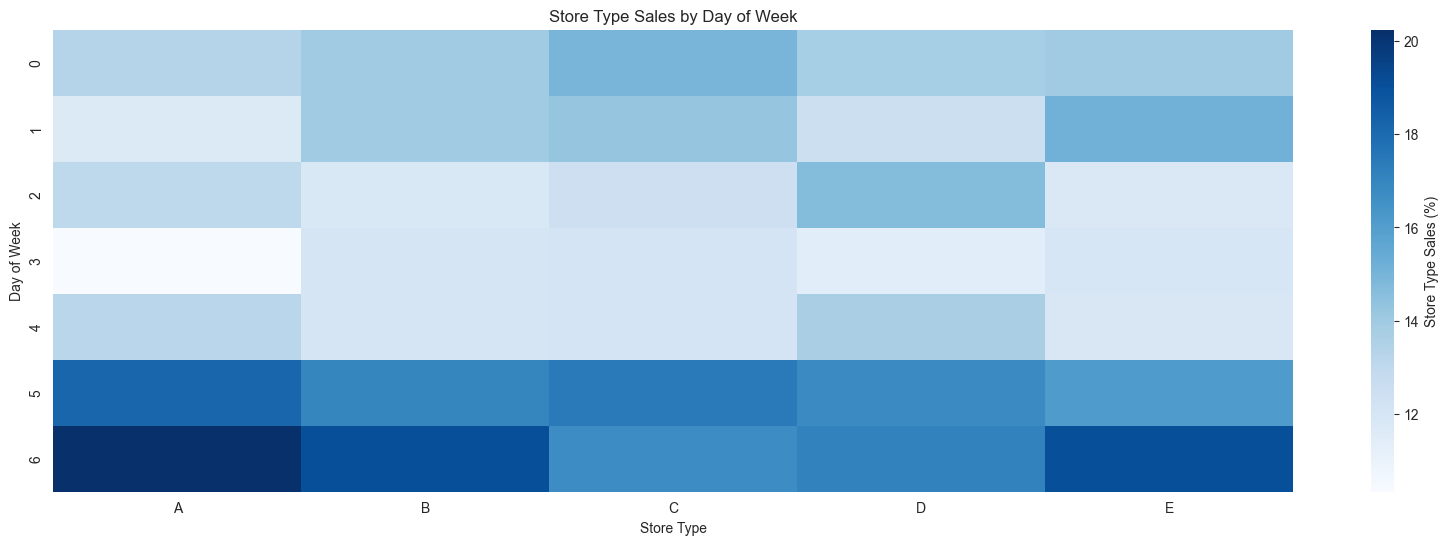

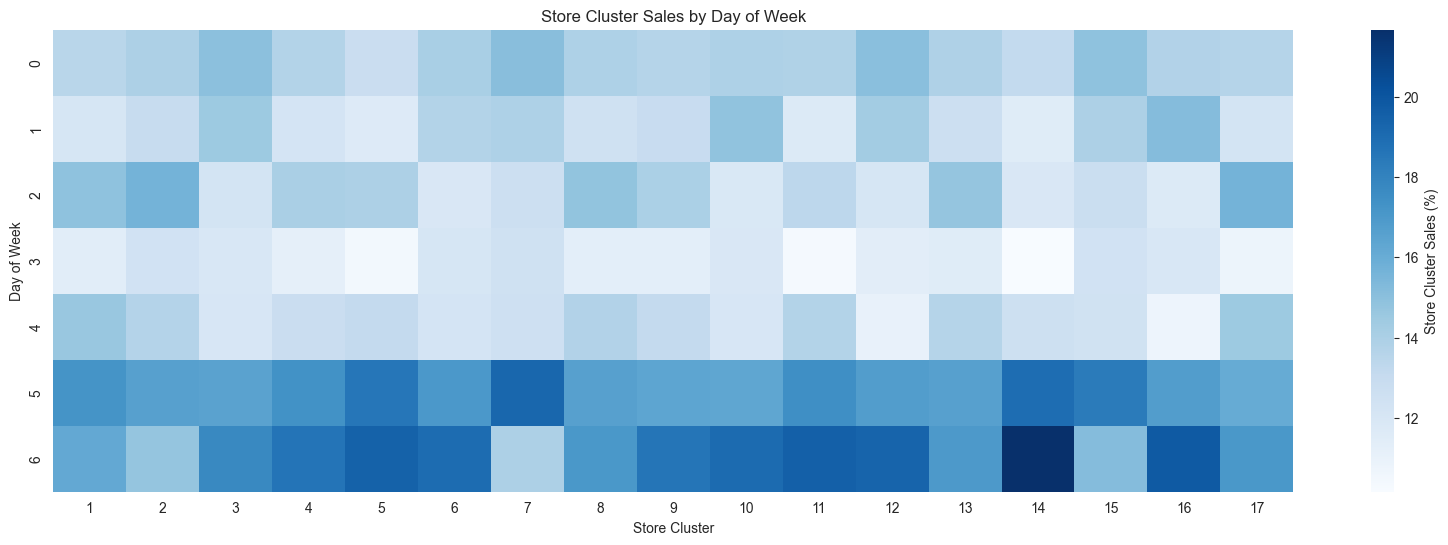

In [76]:
plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_family_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Family Sales (%)"},
)
plt.title("Family Sales by Day of Week")
plt.xlabel("Product Family")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_by_dayofweek_pct, cmap="Blues", cbar_kws={"label": "Store Sales (%)"}
)
plt.title("Store Sales by Day of Week")
plt.xlabel("Store")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_type_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Type Sales (%)"},
)
plt.title("Store Type Sales by Day of Week")
plt.xlabel("Store Type")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(20, 6))
sns.heatmap(
    sales_to_store_cluster_by_dayofweek_pct,
    cmap="Blues",
    cbar_kws={"label": "Store Cluster Sales (%)"},
)
plt.title("Store Cluster Sales by Day of Week")
plt.xlabel("Store Cluster")
plt.ylabel("Day of Week")
plt.show()

## transactions.csv

In [77]:
transactions_df = pd.read_csv(transactions_path)
transactions_df["date"] = pd.to_datetime(transactions_df["date"])

In [78]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [79]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [80]:
print("N NaNs:", transactions_df.isna().sum().sum())

N NaNs: 0


In [81]:
is_max_train_date = np.all(
    transactions_df.groupby("store_nbr")["date"].max() == max_date
)
print(f"Max date in transactions is the same as in train: {is_max_train_date}")

Max date in transactions is the same as in train: True


In [82]:
is_info_about_all_store = transactions_df["store_nbr"].nunique() == n_stores
print(f"transactions.csv contains info about all stores: {is_info_about_all_store}")

transactions.csv contains info about all stores: True


#### Date Gaps

In [83]:
store_25_data = transactions_df[transactions_df["store_nbr"] == 25]
store_25_data = store_25_data[store_25_data["date"] >= "2016-01-01"]

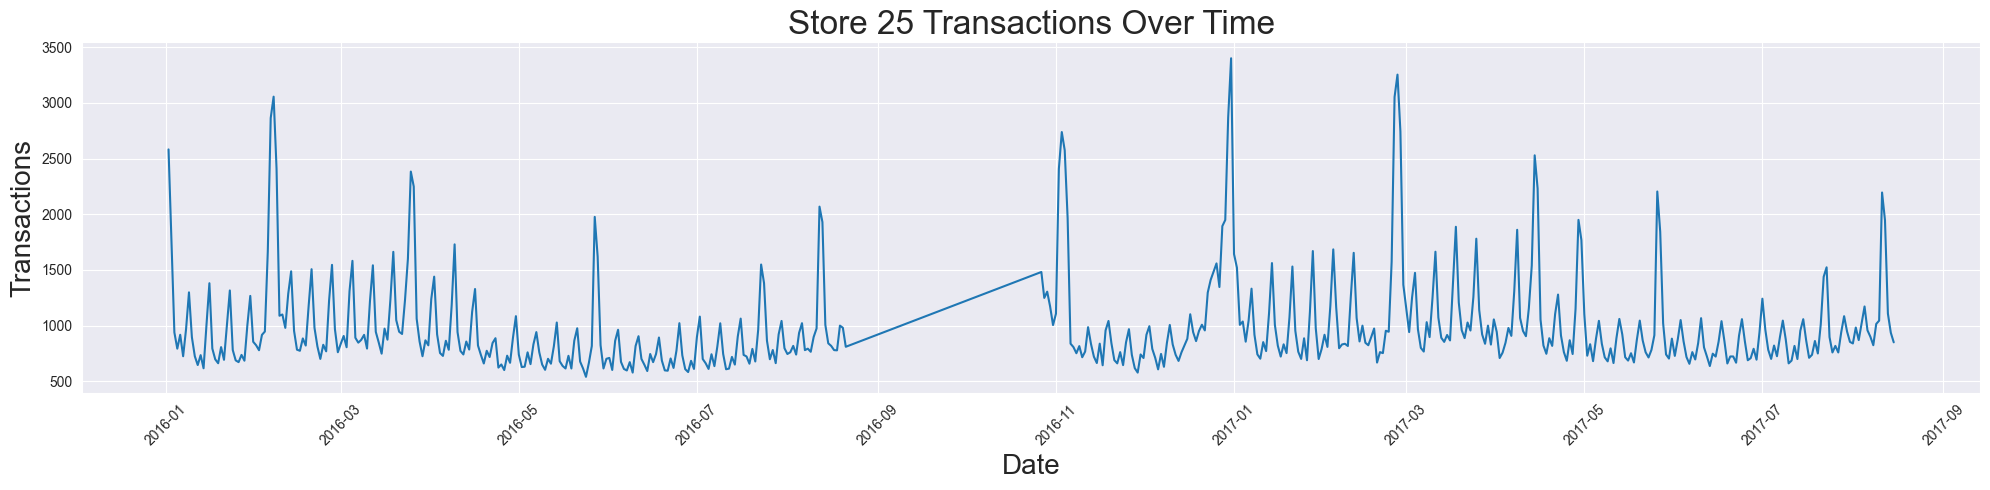

In [84]:
plt.figure(figsize=(20, 5))
plt.plot(store_25_data["date"], store_25_data["transactions"])

plt.title("Store 25 Transactions Over Time", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Transactions", fontsize=20)

plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Transactions Over Time for All Stores

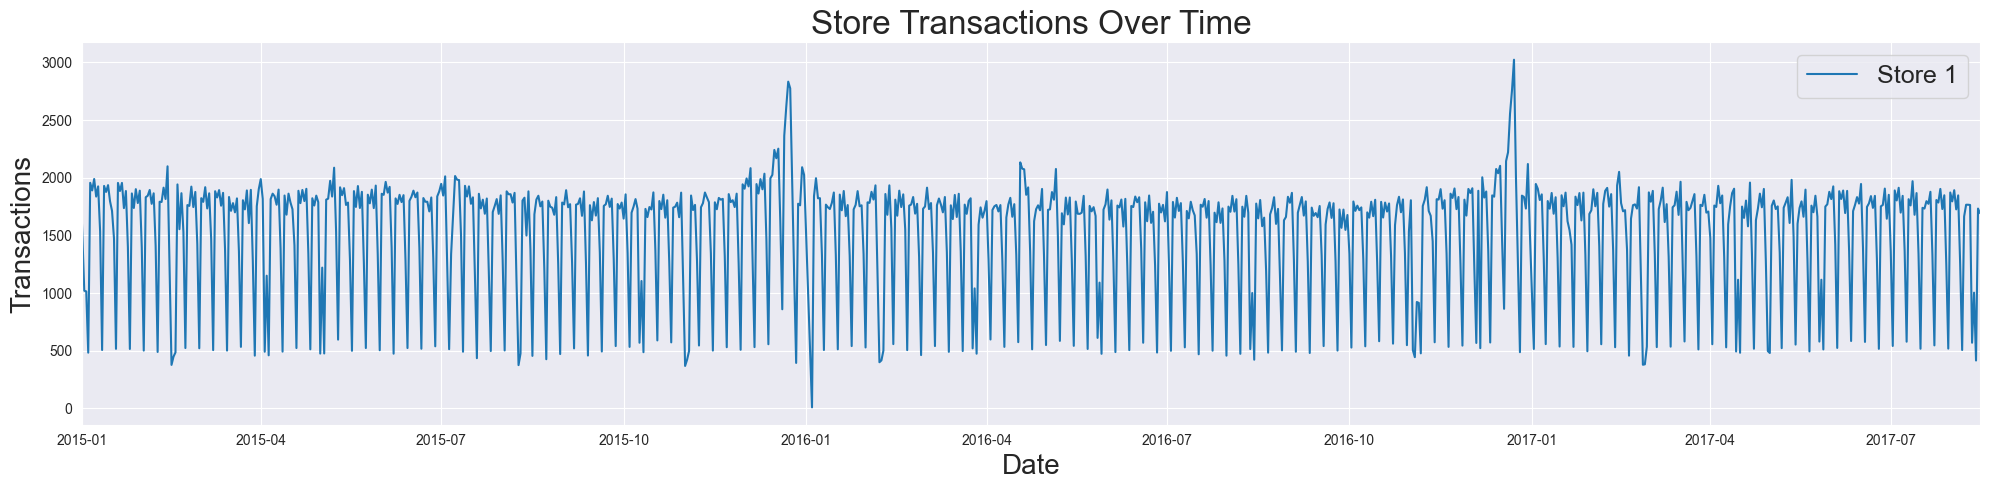

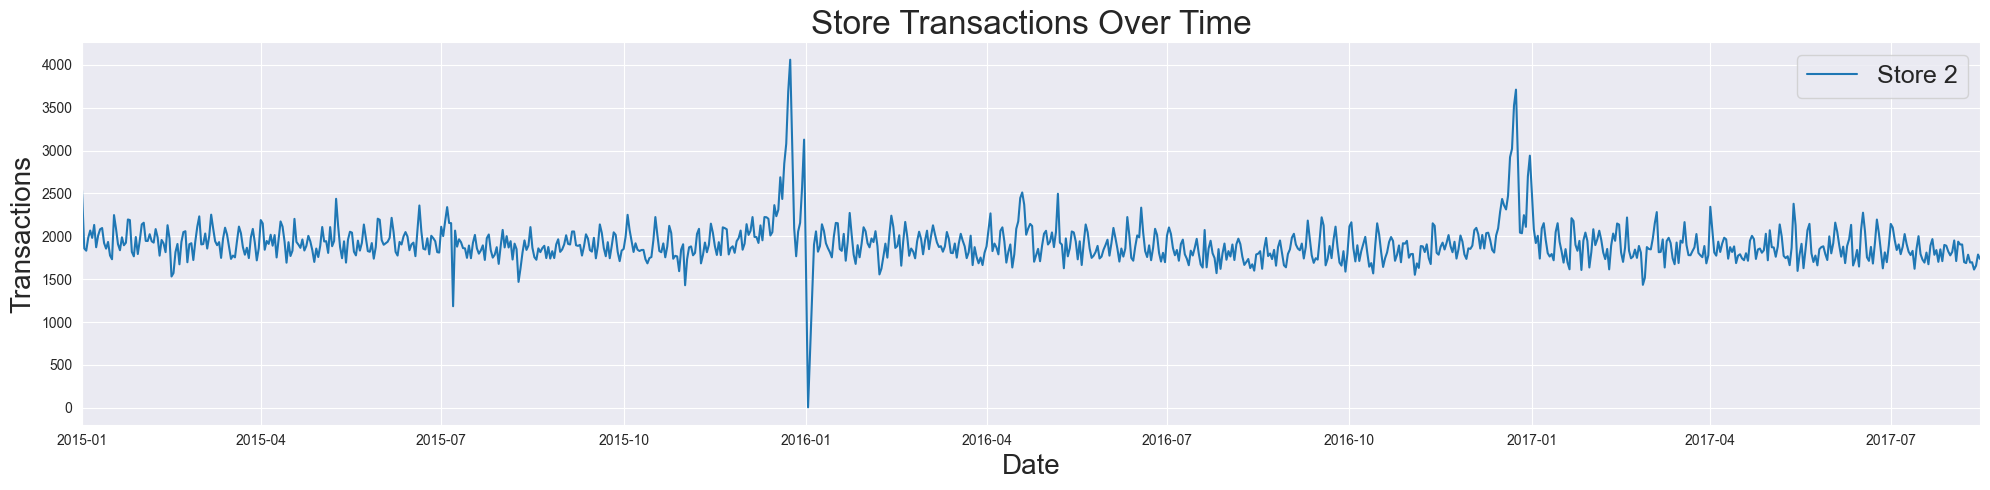

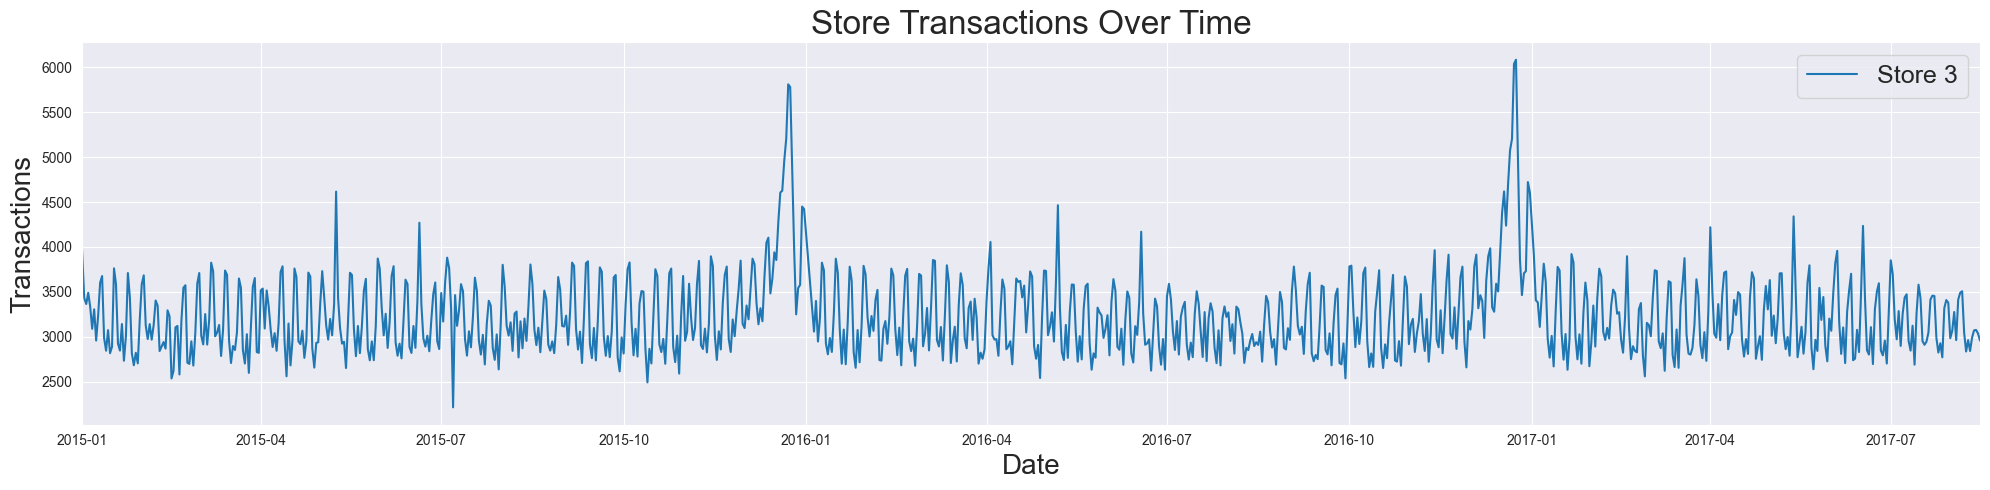

In [85]:
start_date = "2015-01-01"
end_date = transactions_df["date"].max()
stores_to_plot_ = [1, 2, 3]

for i_store in stores_to_plot_:
    plt.figure(figsize=(20, 5))
    df_store = transactions_df[transactions_df["store_nbr"] == i_store]

    plt.plot(df_store["date"], df_store["transactions"], label=f"Store {i_store}")

    plt.title("Store Transactions Over Time", fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Transactions", fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)

    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    plt.tight_layout()
    plt.show()

#### Store Transactions Correlation with Sales

In [86]:
store_sales_per_day = train_df.groupby(["store_nbr", "date"])["sales"].sum()

In [87]:
store_sales_transactions = pd.merge(
    store_sales_per_day, transactions_df, on=["store_nbr", "date"], how="inner"
)

##### Global Correlation

In [88]:
store_sales_transactions[["sales", "transactions"]].corr()

,sales,transactions
sales,1.000000,0.837384
transactions,0.837384,1.000000


##### Per Store Correlation

In [89]:
store_sales_transactions_corr = (
    store_sales_transactions.groupby("store_nbr")[["sales", "transactions"]]
    .corr()
    .iloc[0::2, -1]
).reset_index(level=1, drop=True)

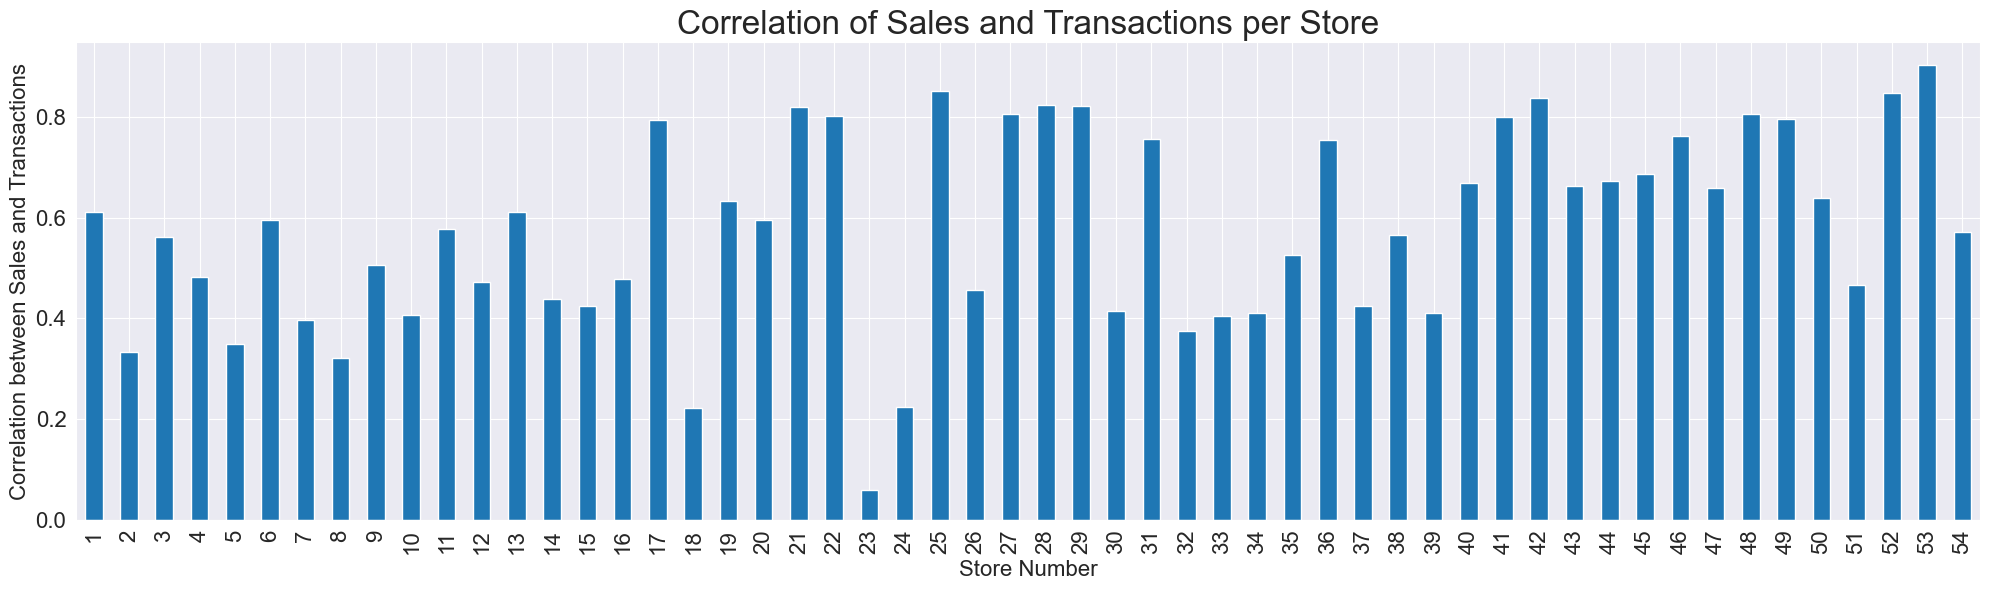

In [90]:
plot_corr_per_store(
    store_sales_transactions_corr, "Correlation of Sales and Transactions per Store"
)

##### Local Correlation

In [91]:
store_sales_transactions["week"] = (
    store_sales_transactions["date"].dt.isocalendar().week
)

In [92]:
columns = ["sales", "transactions"]

weekly_corr = (
    store_sales_transactions.groupby(["store_nbr", "week"])
    .apply(compute_weekly_corr, columns, include_groups=False)
    .reset_index(name="corr")
)

In [93]:
weekly_corr["abs_corr"] = weekly_corr["corr"].abs()

In [94]:
mean_abs_corr_per_store = weekly_corr.groupby("store_nbr")["abs_corr"].mean()

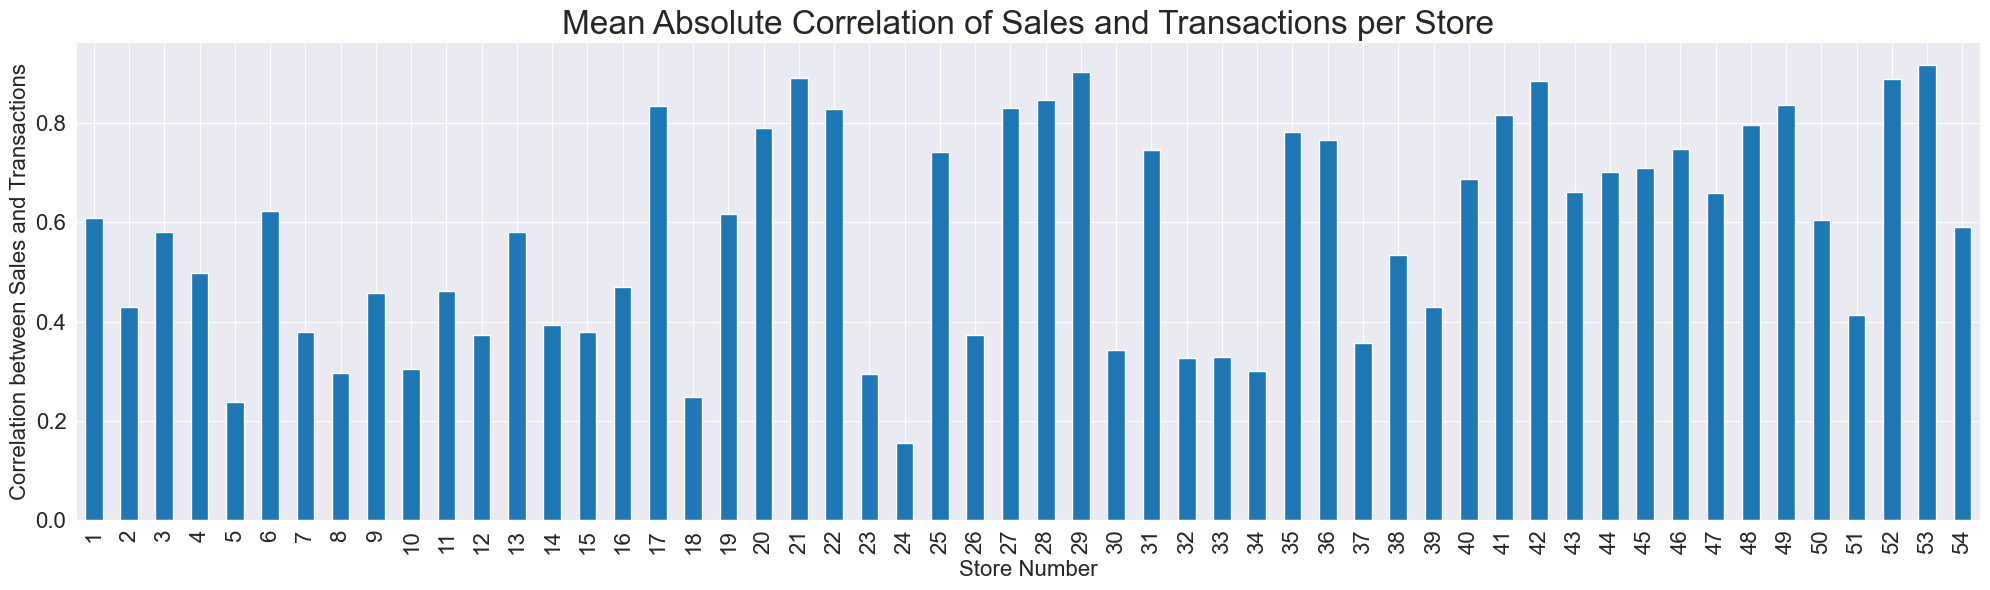

In [95]:
plot_corr_per_store(
    mean_abs_corr_per_store,
    "Mean Absolute Correlation of Sales and Transactions per Store",
)